In [213]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from itertools import combinations

In [215]:
plt.style.use('ggplot')
sns.set(style="whitegrid")

In [217]:
#loading data in
df = pd.read_csv('Sample_Data_Company_XYZ.csv')

In [219]:
df.head()
df.dtypes

Company Name (ID)                 object
Campaign Name                     object
Week Start Date                   object
Advertising Spend                 object
People Reached                    object
Customers Acquired by Campaign    object
Campaign Conversions              object
Ads Delivered                     object
Campaign Revenue                  object
dtype: object

In [221]:
#verifying data integrity
missing_val = df.isnull().sum()
print(missing_val)

duplicates = df.duplicated().sum()
print(f'Duplicates: {duplicates}')

df['Week Start Date'] = pd.to_datetime(df['Week Start Date'])
df['Advertising Spend'] = df['Advertising Spend'].str.replace(r'[$,]', '', regex=True).astype(float)
df['Campaign Revenue'] = df['Campaign Revenue'].str.replace(r'[$,]', '', regex=True).astype(float)
df['Customers Acquired by Campaign'] = df['Customers Acquired by Campaign'].str.replace(',', '', regex=True).astype(float)
df['People Reached'] = df['People Reached'].str.replace(',', '', regex=True).astype(float)
df['Campaign Conversions'] = df['Campaign Conversions'].str.replace(',', '', regex=True).astype(float)
df['Ads Delivered'] = df['Ads Delivered'].str.replace(',', '', regex=True).astype(float)

Company Name (ID)                 0
Campaign Name                     0
Week Start Date                   0
Advertising Spend                 0
People Reached                    0
Customers Acquired by Campaign    0
Campaign Conversions              0
Ads Delivered                     0
Campaign Revenue                  0
dtype: int64
Duplicates: 0


In [224]:
df.head()

,Company Name (ID),Campaign Name,Week Start Date,Advertising Spend,People Reached,Customers Acquired by Campaign,Campaign Conversions,Ads Delivered,Campaign Revenue
0,Brand XYZ,Campaign A,2020-07-26,57.0,7786.0,2.0,2.0,10007.0,203.0
1,Brand XYZ,Campaign A,2020-08-02,1140.0,124987.0,28.0,29.0,199975.0,7976.0
2,Brand XYZ,Campaign A,2020-08-02,924.0,95252.0,7.0,7.0,162167.0,1130.0
3,Brand XYZ,Campaign A,2020-08-09,853.0,87318.0,56.0,58.0,149655.0,9401.0
4,Brand XYZ,Campaign A,2020-08-09,915.0,97319.0,16.0,16.0,160593.0,2276.0


In [226]:
mean_revenue = df['Campaign Revenue'].mean()
std_revenue = df['Campaign Revenue'].std()

# Define a threshold for identifying outliers
threshold = mean_revenue + 10 * std_revenue

# Identify rows with outliers
outliers = df[df['Campaign Revenue'] > threshold]
print("Outliers:")
print(outliers)

#remove outliers
non_outliers_mean = df[df['Campaign Revenue'] <= threshold]['Campaign Revenue'].mean()
df.loc[df['Campaign Revenue'] > threshold, 'Campaign Revenue'] = non_outliers_mean

Outliers:
   Company Name (ID) Campaign Name Week Start Date  Advertising Spend  \
45         Brand XYZ    Campaign D      2020-04-05             1365.0   

    People Reached  Customers Acquired by Campaign  Campaign Conversions  \
45         34890.0                            25.0                  26.0   

    Ads Delivered  Campaign Revenue  
45       227517.0      1.030402e+12  


In [228]:
#establish KPIs
df['Profit'] = df['Campaign Revenue']*0.05
df['Conversion Rate'] = df['Campaign Conversions'] / df['People Reached']
df['Cost per Acquisition'] = df['Advertising Spend']/df['Customers Acquired by Campaign']
df['ROAS'] = df['Campaign Revenue'] / df['Advertising Spend']

# Replace invalid values with 0
df.fillna(0, inplace=True)
df.replace([np.inf, -np.inf], 0, inplace=True)

In [230]:
df.head()

,Company Name (ID),Campaign Name,Week Start Date,Advertising Spend,People Reached,Customers Acquired by Campaign,Campaign Conversions,Ads Delivered,Campaign Revenue,Profit,Conversion Rate,Cost per Acquisition,ROAS
0,Brand XYZ,Campaign A,2020-07-26,57.0,7786.0,2.0,2.0,10007.0,203.0,10.15,0.000257,28.500000,3.561404
1,Brand XYZ,Campaign A,2020-08-02,1140.0,124987.0,28.0,29.0,199975.0,7976.0,398.80,0.000232,40.714286,6.996491
2,Brand XYZ,Campaign A,2020-08-02,924.0,95252.0,7.0,7.0,162167.0,1130.0,56.50,0.000073,132.000000,1.222944
3,Brand XYZ,Campaign A,2020-08-09,853.0,87318.0,56.0,58.0,149655.0,9401.0,470.05,0.000664,15.232143,11.021102
4,Brand XYZ,Campaign A,2020-08-09,915.0,97319.0,16.0,16.0,160593.0,2276.0,113.80,0.000164,57.187500,2.487432


  Campaign Name  Conversion Rate
0    Campaign A         0.000561
1    Campaign B         0.682427
2    Campaign C         0.416084
3    Campaign D         0.149838
4    Campaign E         0.173132
5    Campaign F         0.001707
6    Campaign G         3.047479


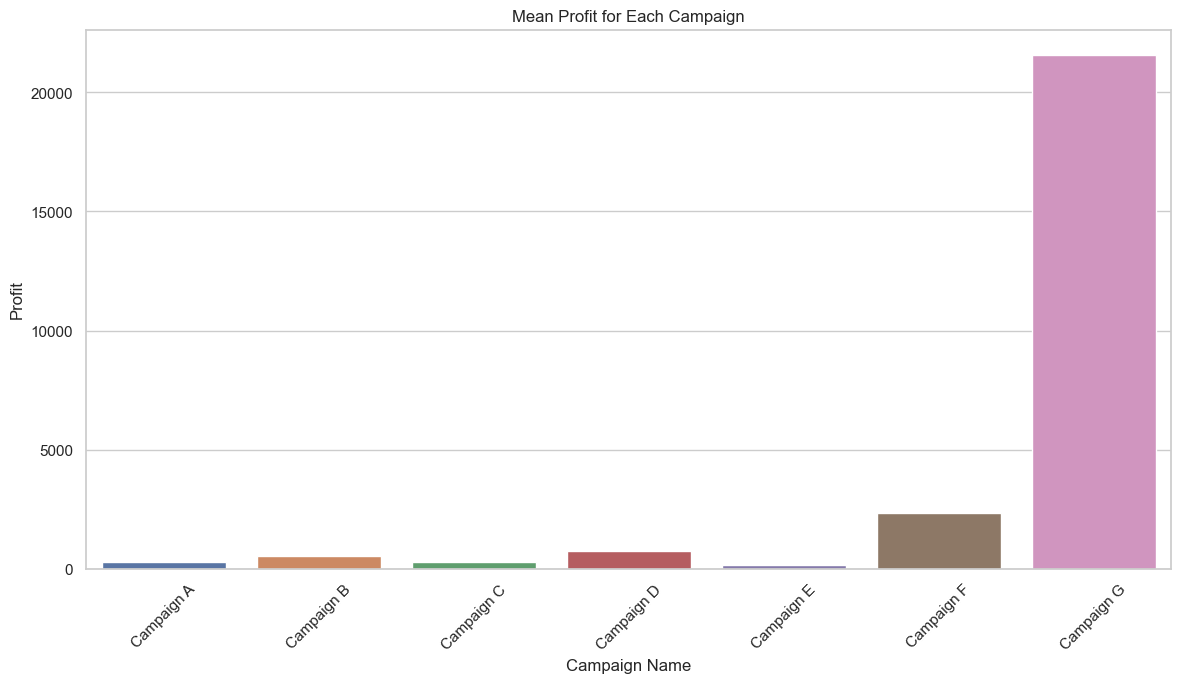

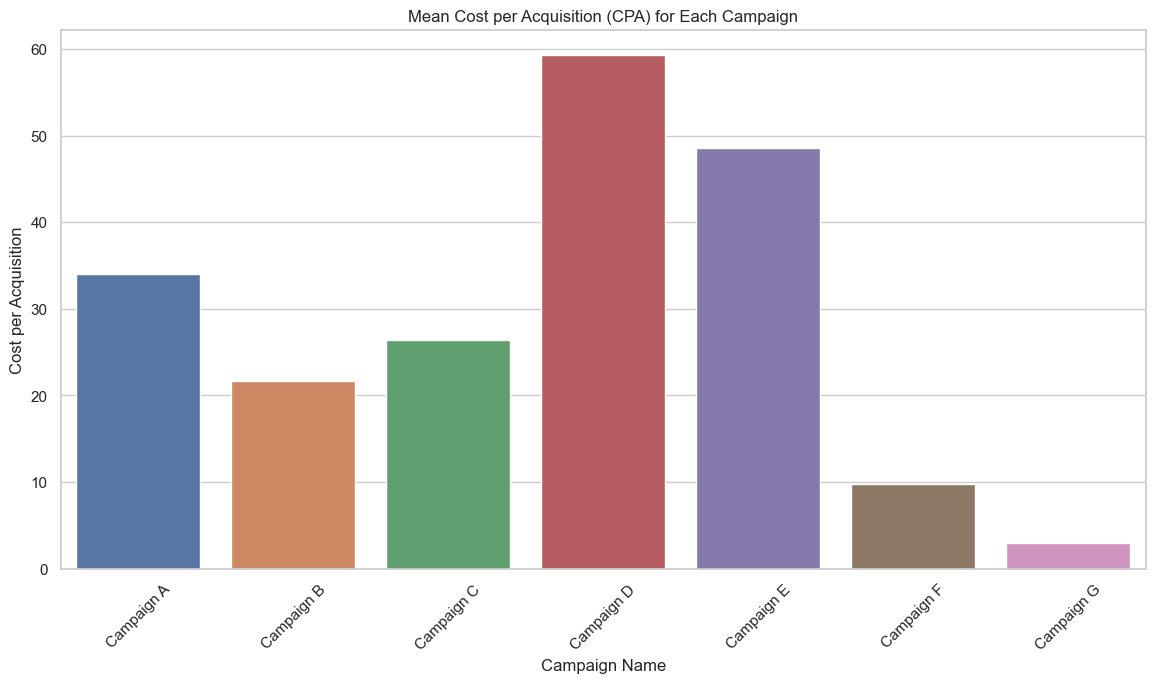

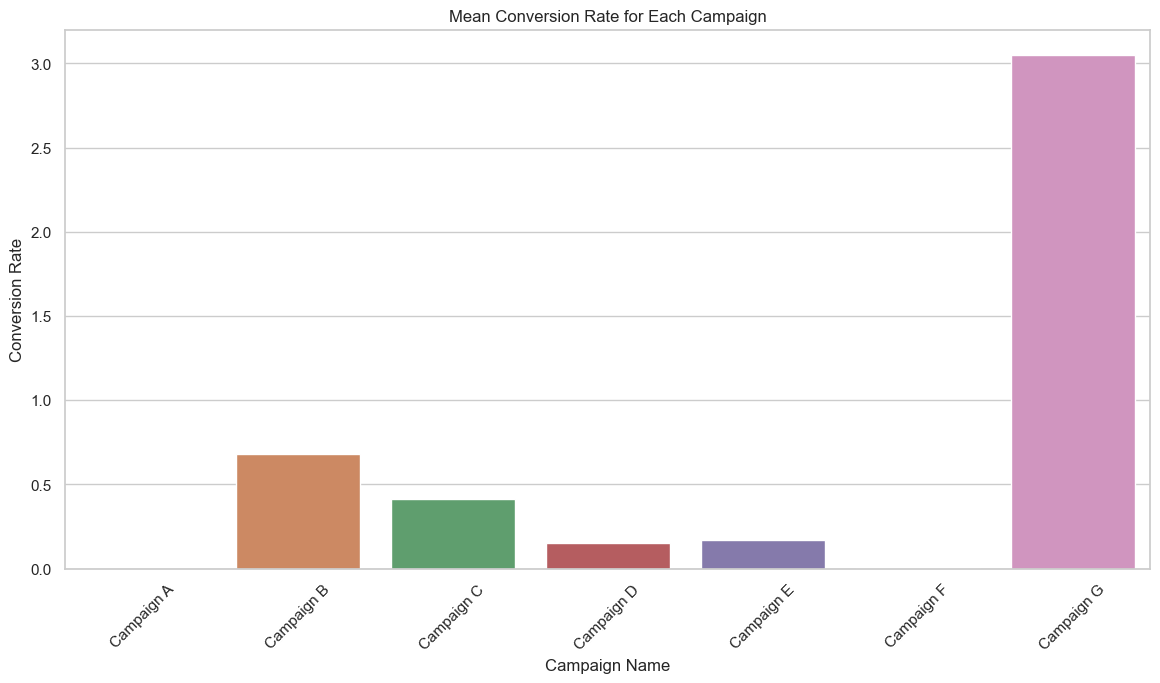

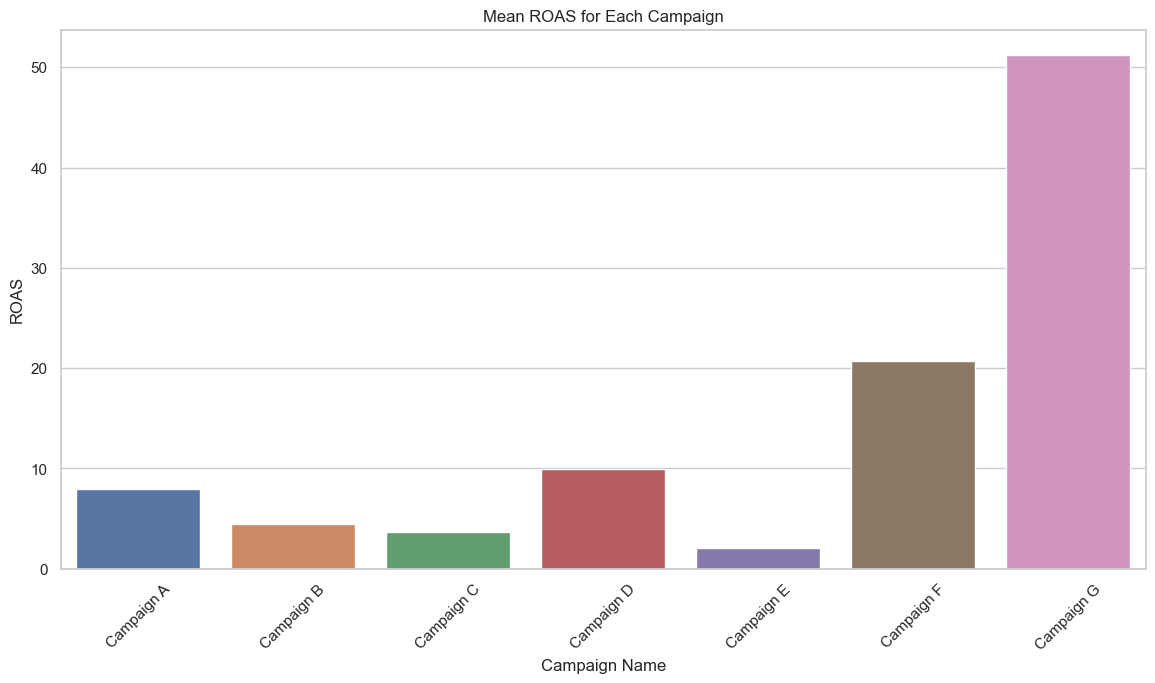

In [236]:
# calculate mean by campaign
mean_profit = df.groupby('Campaign Name')['Profit'].mean().reset_index()
mean_cpa = df.groupby('Campaign Name')['Cost per Acquisition'].mean().reset_index()
mean_conversion_rate = df.groupby('Campaign Name')['Conversion Rate'].mean().reset_index()
mean_roas = df.groupby('Campaign Name')['ROAS'].mean().reset_index()

print(mean_conversion_rate)
# mean Profit for Each Campaign
plt.figure(figsize=(14, 7))
sns.barplot(x='Campaign Name', y='Profit', hue='Campaign Name', data=mean_profit)
plt.title('Mean Profit for Each Campaign')
plt.xticks(rotation=45)
plt.show()

# mean Cost per Acquisition (CPA) for Each Campaign
plt.figure(figsize=(14, 7))
sns.barplot(x='Campaign Name', y='Cost per Acquisition', hue='Campaign Name', data=mean_cpa)
plt.title('Mean Cost per Acquisition (CPA) for Each Campaign')
plt.xticks(rotation=45)
plt.show()

# mean Conversion Rate for each campaign
plt.figure(figsize=(14, 7))
sns.barplot(x='Campaign Name', y='Conversion Rate', hue='Campaign Name', data=mean_conversion_rate)
plt.title('Mean Conversion Rate for Each Campaign')
plt.xticks(rotation=45)
plt.show()

# mean ROAS for each campaign
plt.figure(figsize=(14, 7))
sns.barplot(x='Campaign Name', y='ROAS', hue='Campaign Name', data=mean_roas)
plt.title('Mean ROAS for Each Campaign')
plt.xticks(rotation=45)
plt.show()

In [170]:
# Perform ANOVA tests for all campaigns
campaigns = df['Campaign Name'].unique()

# Prepare data for ANOVA
cpa_data = [df[df['Campaign Name'] == campaign]['Cost per Acquisition'].dropna() for campaign in campaigns]
profit_data = [df[df['Campaign Name'] == campaign]['Profit'].dropna() for campaign in campaigns]
conversion_rate_data = [df[df['Campaign Name'] == campaign]['Conversion Rate'].dropna() for campaign in campaigns]
roas_data = [df[df['Campaign Name'] == campaign]['ROAS'].dropna() for campaign in campaigns]

# ANOVA test for Cost per Acquisition
anova_cpa = stats.f_oneway(*cpa_data)
print('ANOVA result for Cost per Acquisition by Campaign:', anova_cpa)

# ANOVA test for Profit
anova_profit = stats.f_oneway(*profit_data)
print('ANOVA result for Profit by Campaign:', anova_profit)

# ANOVA test for Conversion Rate
anova_conversion_rate = stats.f_oneway(*conversion_rate_data)
print('ANOVA result for Conversion Rate by Campaign:', anova_conversion_rate)

# ANOVA test for ROAS
anova_roas = stats.f_oneway(*roas_data)
print('ANOVA result for ROAS by Campaign:', anova_roas)

ANOVA result for Cost per Acquisition by Campaign: F_onewayResult(statistic=3.8635351992449354, pvalue=0.0016066599309535834)
ANOVA result for Profit by Campaign: F_onewayResult(statistic=11.644794827809513, pvalue=6.058208362670308e-10)
ANOVA result for Conversion Rate by Campaign: F_onewayResult(statistic=0.24831622428373162, pvalue=0.9589906598861666)
ANOVA result for ROAS by Campaign: F_onewayResult(statistic=16.521018569934594, pvalue=2.701360327798145e-13)


In [172]:
# Perform Tukey HSD test for CPA
tukey_cpa = pairwise_tukeyhsd(endog=df['Cost per Acquisition'], groups=df['Campaign Name'], alpha=0.05)
print(tukey_cpa)

# Perform Tukey HSD test for Profit
tukey_profit = pairwise_tukeyhsd(endog=df['Profit'], groups=df['Campaign Name'], alpha=0.05)
print(tukey_profit)

# Perform Tukey HSD test for Conversion Rate
tukey_conversion_rate = pairwise_tukeyhsd(endog=df['Conversion Rate'], groups=df['Campaign Name'], alpha=0.05)
print(tukey_conversion_rate)

# Perform Tukey HSD test for ROAS
tukey_roas = pairwise_tukeyhsd(endog=df['ROAS'], groups=df['Campaign Name'], alpha=0.05)
print(tukey_roas)

      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
  group1     group2   meandiff p-adj    lower    upper   reject
---------------------------------------------------------------
Campaign A Campaign B -12.3289 0.9928  -65.9193  41.2615  False
Campaign A Campaign C  -7.6407 0.9995  -61.2311  45.9497  False
Campaign A Campaign D  25.2206 0.7926  -28.3698   78.811  False
Campaign A Campaign E  14.5283 0.9829  -39.0621  68.1187  False
Campaign A Campaign F -24.2911 0.9488  -96.0302   47.448  False
Campaign A Campaign G -31.0741 0.3856  -76.4822  14.3341  False
Campaign B Campaign C   4.6882    1.0  -45.5841  54.9604  False
Campaign B Campaign D  37.5495 0.2807  -12.7227  87.8218  False
Campaign B Campaign E  26.8572 0.6786   -23.415  77.1294  False
Campaign B Campaign F -11.9622 0.9985  -81.2577  57.3333  False
Campaign B Campaign G -18.7452 0.8214  -60.1851  22.6947  False
Campaign C Campaign D  32.8614 0.4427  -17.4109  83.1336  False
Campaign C Campaign E   22.169 0.8383  -

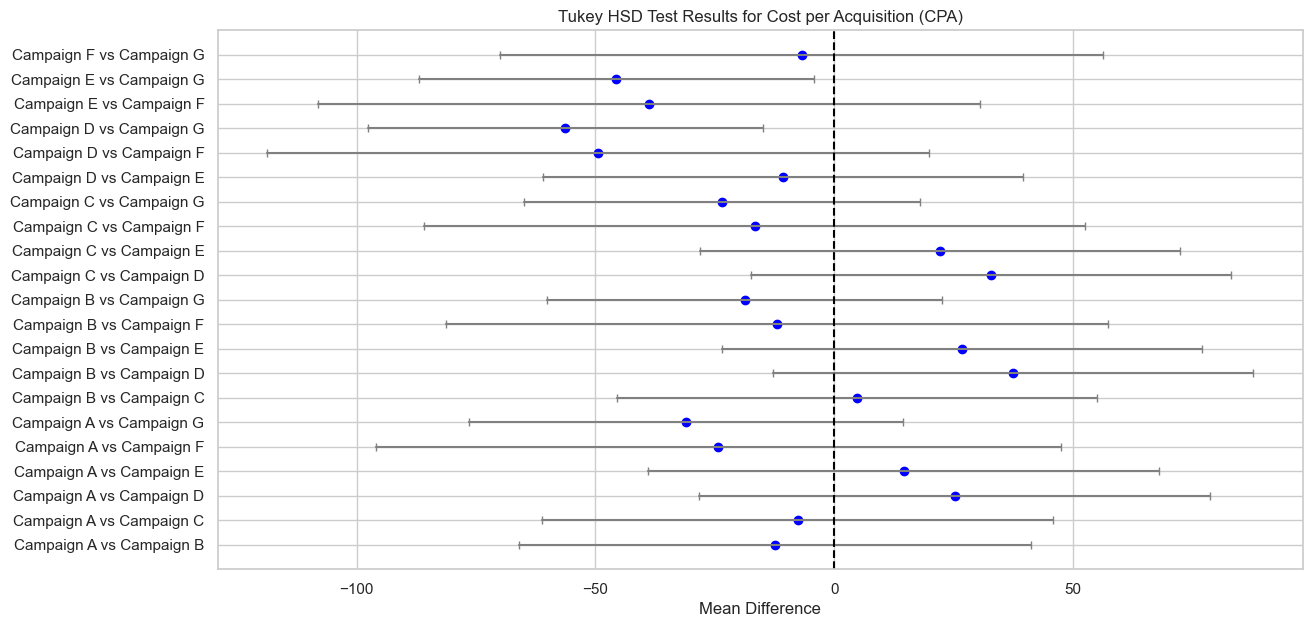

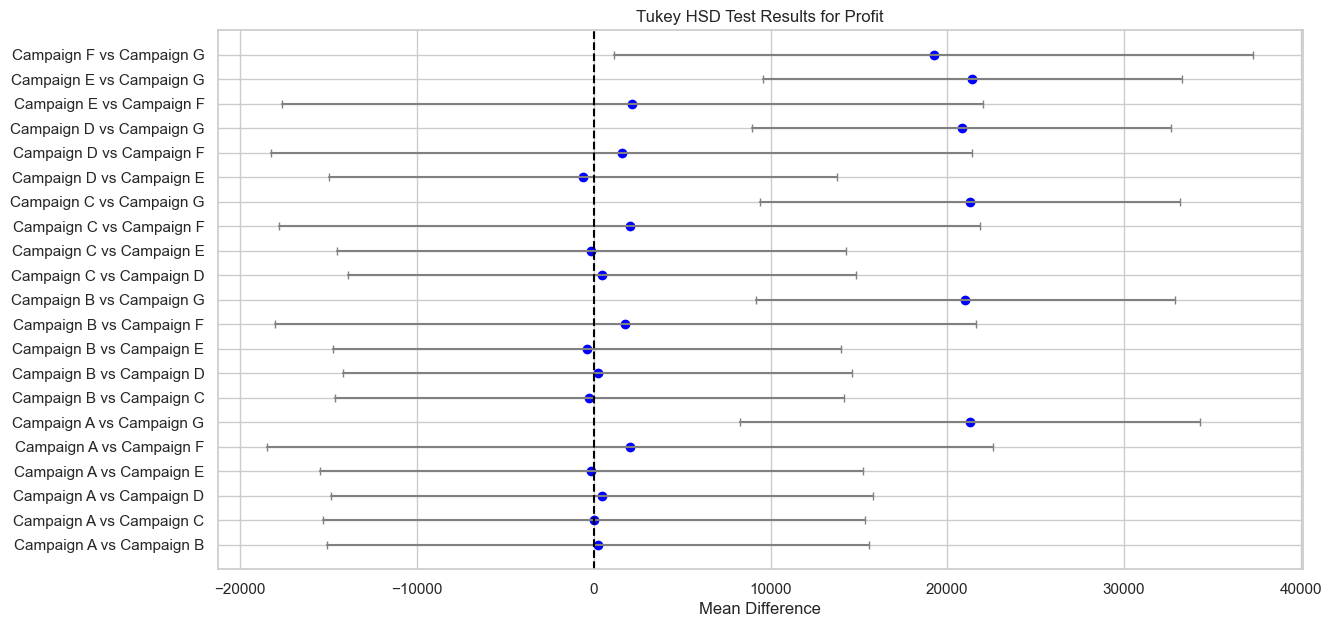

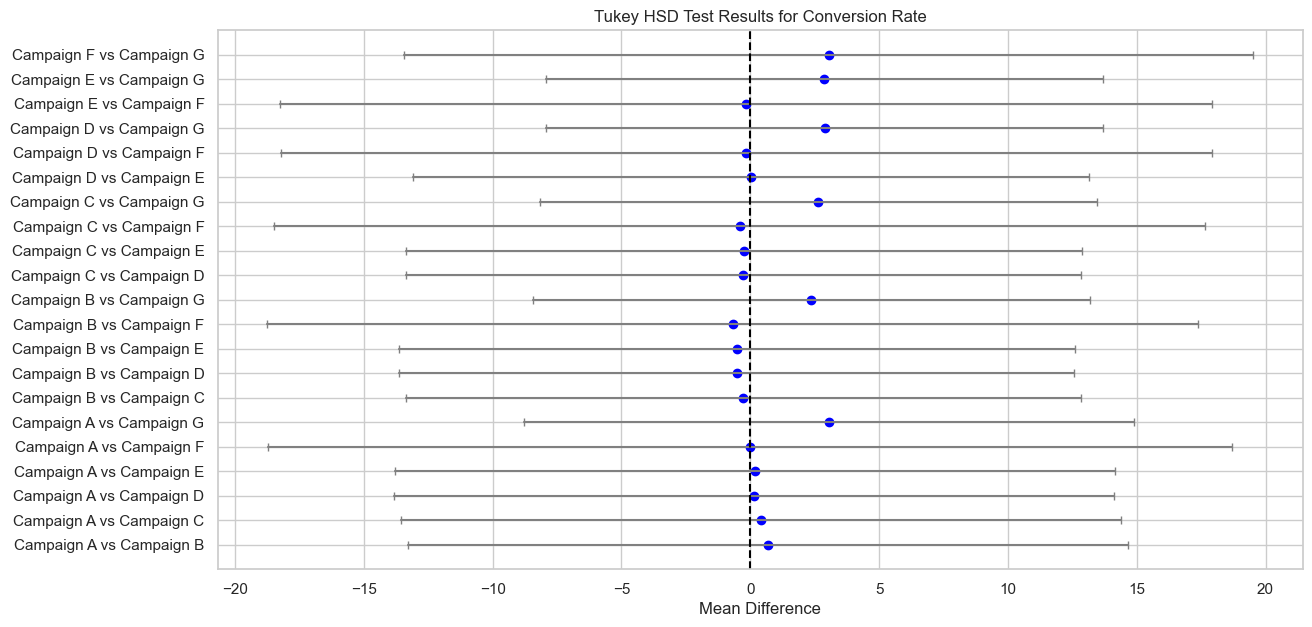

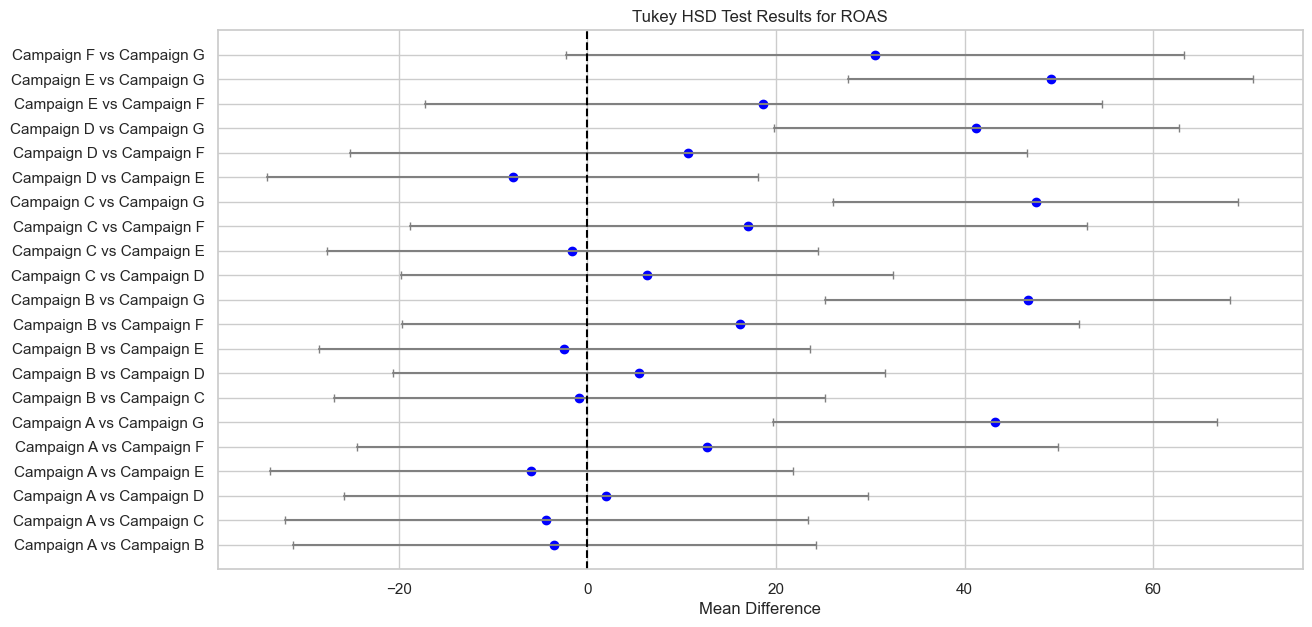

In [209]:
def plot_tukey_hsd(tukey_result, title):
    tukey_df = pd.DataFrame(data=tukey_result._results_table.data[1:], columns=tukey_result._results_table.data[0])

    plt.figure(figsize=(14, 7))
    for i, row in tukey_df.iterrows():
        plt.plot([row['lower'], row['upper']], [i, i], color='grey', marker='|')
        plt.scatter(row['meandiff'], i, color='red' if row['reject'] == 'True' else 'blue')

    plt.yticks(range(len(tukey_df)), tukey_df['group1'] + ' vs ' + tukey_df['group2'])
    plt.axvline(x=0, color='black', linestyle='--')
    plt.xlabel('Mean Difference')
    plt.title(title)
    plt.grid(True)
    plt.show()

# Plot Tukey HSD results for each test
plot_tukey_hsd(tukey_cpa, 'Tukey HSD Test Results for Cost per Acquisition (CPA)')
plot_tukey_hsd(tukey_profit, 'Tukey HSD Test Results for Profit')
plot_tukey_hsd(tukey_conversion_rate, 'Tukey HSD Test Results for Conversion Rate')
plot_tukey_hsd(tukey_roas, 'Tukey HSD Test Results for ROAS')

In [238]:
df.dtypes

Company Name (ID)                         object
Campaign Name                             object
Week Start Date                   datetime64[ns]
Advertising Spend                        float64
People Reached                           float64
Customers Acquired by Campaign           float64
Campaign Conversions                     float64
Ads Delivered                            float64
Campaign Revenue                         float64
Profit                                   float64
Conversion Rate                          float64
Cost per Acquisition                     float64
ROAS                                     float64
dtype: object

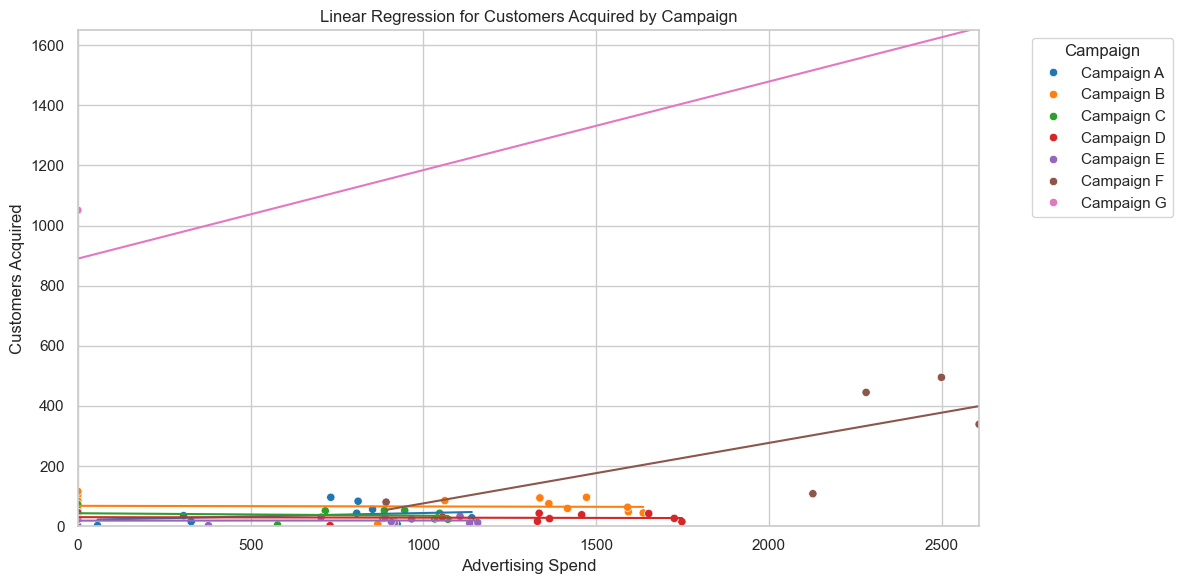

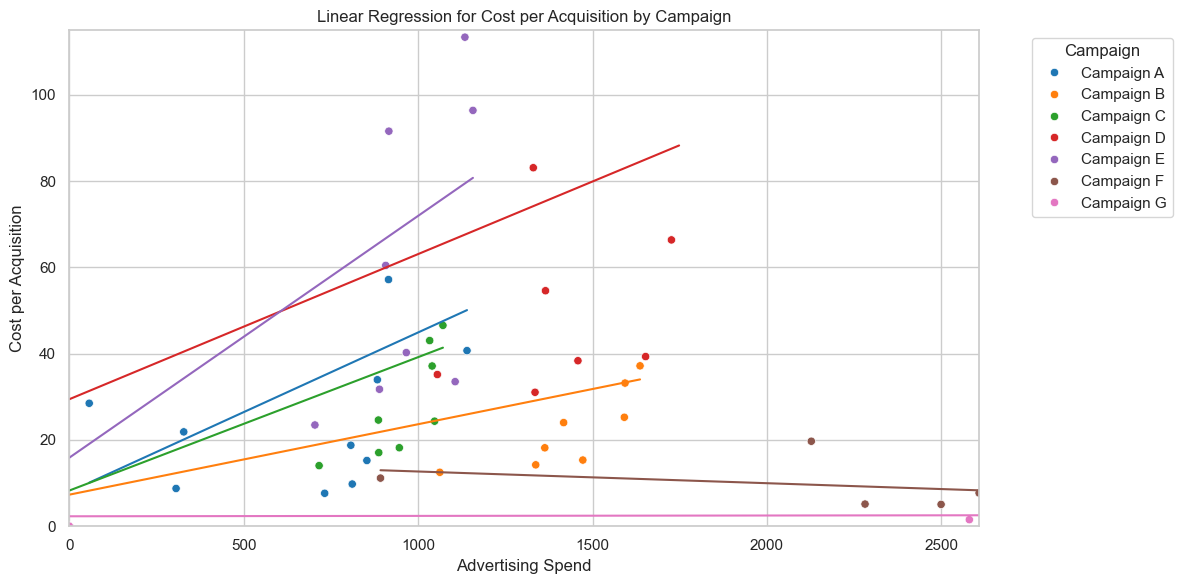

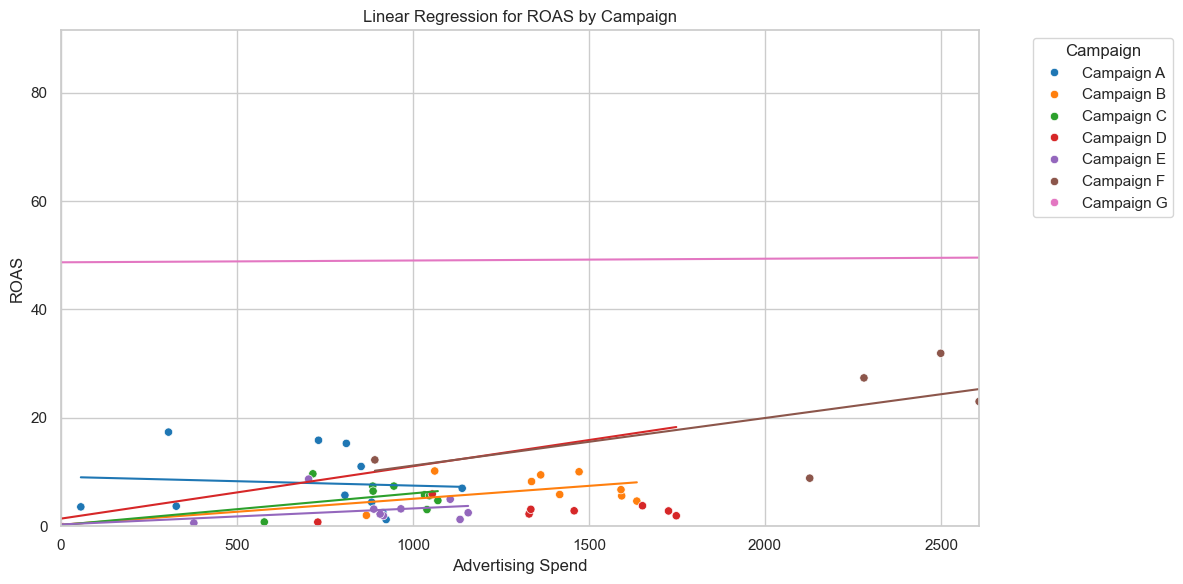

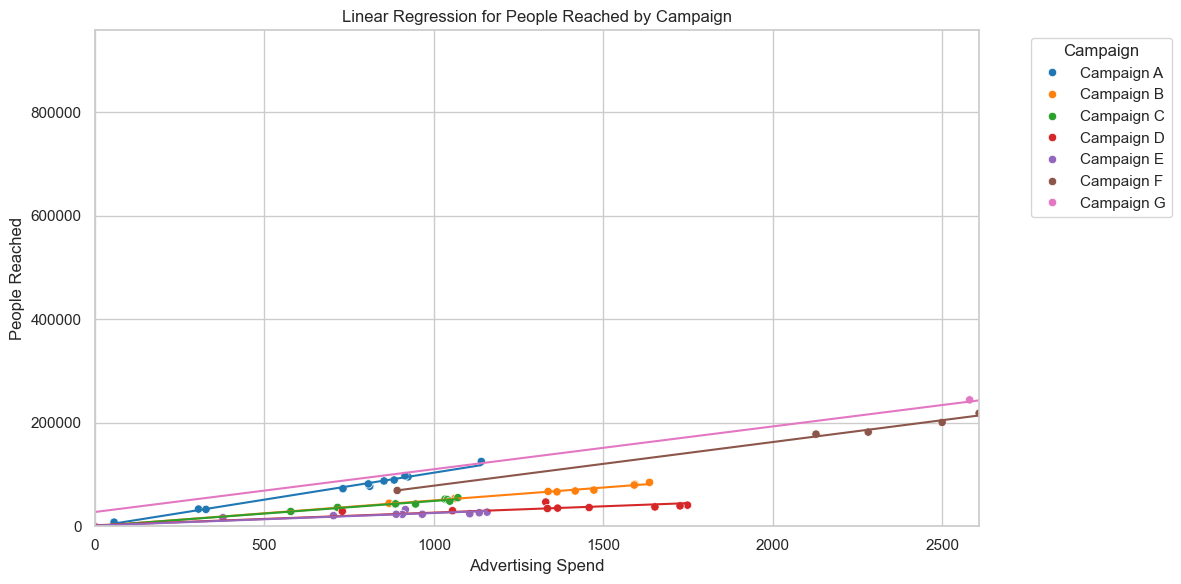

In [282]:
#fit and predict using linear regression for each campaign
def fit_predict_linear_regression(df, x_col, y_col):
    predictions = pd.DataFrame()
    
    for campaign in df['Campaign Name'].unique():
        df_campaign = df[df['Campaign Name'] == campaign].copy()  
        X = df_campaign[[x_col]]
        y = df_campaign[y_col]
        
        model = LinearRegression()
        model.fit(X, y)
        
        df_campaign['Prediction'] = model.predict(X)
        predictions = pd.concat([predictions, df_campaign], axis=0)
    
    return predictions


predictions_customers = fit_predict_linear_regression(df, 'Advertising Spend', 'Customers Acquired by Campaign')
predictions_cpa = fit_predict_linear_regression(df, 'Advertising Spend', 'Cost per Acquisition')
predictions_roas = fit_predict_linear_regression(df, 'Advertising Spend', 'ROAS')
predictions_people_reached = fit_predict_linear_regression(df, 'Advertising Spend', 'People Reached')

predictions_customers.rename(columns={'Prediction': 'Predicted Customers Acquired'}, inplace=True)
predictions_cpa.rename(columns={'Prediction': 'Predicted Cost per Acquisition'}, inplace=True)
predictions_roas.rename(columns={'Prediction': 'Predicted ROAS'}, inplace=True)
predictions_people_reached.rename(columns={'Prediction': 'Predicted People Reached'}, inplace=True)

#set xlim range
max_spend_per_campaign = df.groupby('Campaign Name')['Advertising Spend'].max()
second_longest_cutoff = max_spend_per_campaign.sort_values(ascending=False).iloc[1]

#ylim ranges
ylim_range_customers = (predictions_customers['Customers Acquired by Campaign'].min(), predictions_customers['Customers Acquired by Campaign'].quantile(0.80))
ylim_range_cpa = (predictions_cpa['Cost per Acquisition'].min(), predictions_cpa['Cost per Acquisition'].quantile(0.95))
ylim_range_roas = (predictions_roas['ROAS'].min(), predictions_roas['ROAS'].quantile(0.95))
ylim_range_people_reached = (predictions_people_reached['People Reached'].min(), predictions_people_reached['People Reached'].quantile(0.95))

#Plot
#Customers Acquired
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Advertising Spend', y='Customers Acquired by Campaign', hue='Campaign Name', data=predictions_customers, palette='tab10')
sns.lineplot(x='Advertising Spend', y='Predicted Customers Acquired', hue='Campaign Name', data=predictions_customers, palette='tab10', legend=False)
plt.title('Linear Regression for Customers Acquired by Campaign')
plt.xlabel('Advertising Spend')
plt.ylabel('Customers Acquired')
plt.xlim(0, second_longest_cutoff)
plt.ylim(ylim_range_customers)
plt.legend(title='Campaign', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# CPA
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Advertising Spend', y='Cost per Acquisition', hue='Campaign Name', data=predictions_cpa, palette='tab10')
sns.lineplot(x='Advertising Spend', y='Predicted Cost per Acquisition', hue='Campaign Name', data=predictions_cpa, palette='tab10', legend=False)
plt.title('Linear Regression for Cost per Acquisition by Campaign')
plt.xlabel('Advertising Spend')
plt.ylabel('Cost per Acquisition')
plt.xlim(0, second_longest_cutoff)
plt.ylim(ylim_range_cpa)
plt.legend(title='Campaign', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# ROAS
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Advertising Spend', y='ROAS', hue='Campaign Name', data=predictions_roas, palette='tab10')
sns.lineplot(x='Advertising Spend', y='Predicted ROAS', hue='Campaign Name', data=predictions_roas, palette='tab10', legend=False)
plt.title('Linear Regression for ROAS by Campaign')
plt.xlabel('Advertising Spend')
plt.ylabel('ROAS')
plt.xlim(0, second_longest_cutoff)
plt.ylim(ylim_range_roas)
plt.legend(title='Campaign', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# People Reached
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Advertising Spend', y='People Reached', hue='Campaign Name', data=predictions_people_reached, palette='tab10')
sns.lineplot(x='Advertising Spend', y='Predicted People Reached', hue='Campaign Name', data=predictions_people_reached, palette='tab10', legend=False)
plt.title('Linear Regression for People Reached by Campaign')
plt.xlabel('Advertising Spend')
plt.ylabel('People Reached')
plt.xlim(0, second_longest_cutoff)
plt.ylim(ylim_range_people_reached)
plt.legend(title='Campaign', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
